<a href="https://colab.research.google.com/github/kulkarni-aish-northeastern/Airline-Reservation-Management-System/blob/main/Research_Report_Aishwarya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Research Report on Diease Diagnosis based on Chest X-Rays

Report prepared by Aishwarya Kulkarni NUID(002792060) and Divya Kulkarni NUID(002926600)

### About the dataset

National Institutes of Health Chest X-Ray Dataset
Chest X-ray exams are one of the most frequent and cost-effective medical imaging examinations available. However, clinical diagnosis of a chest X-ray can be challenging and sometimes more difficult than diagnosis via chest CT imaging. The lack of large publicly available datasets with annotations means it is still very difficult, if not impossible, to achieve clinically relevant computer-aided detection and diagnosis (CAD) in real world medical sites with chest X-rays. One major hurdle in creating large X-ray image datasets is the lack resources for labeling so many images. Prior to the release of this dataset, Openi was the largest publicly available source of chest X-ray images with 4,143 images available.

This NIH Chest X-ray Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning. The original radiology reports are not publicly available but you can find more details on the labeling process in this Open Access paper: "ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases." (Wang et al.)


#### Class descriptions
There are 15 classes (14 diseases, and one for "No findings"). Images can be classified as "No findings" or one or more disease classes:

1. Atelectasis
2. Cardiomegaly
3. Consolidation
4. Edema
5. Effusion
6. Emphysema
7. Fibrosis
8. Infiltration
9. Mass
10. Nodule
11. Pneumonia
12. Pneumothorax
13. Pleural
14. No Findings


#### Downloaded the dataset using Kaggle API in our Colab file



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"divyaskul","key":"45f52ef39c3b833f783fed1d8e63cc02"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pwd

/content


In [ ]:
!kaggle datasets download -d khanfashee/nih224folderwise-data

Dataset URL: https://www.kaggle.com/datasets/khanfashee/nih224folderwise-data
License(s): CC0-1.0
100% 2.87G/2.87G [00:19<00:00, 199MB/s]
100% 2.87G/2.87G [00:19<00:00, 155MB/s]


In [ ]:
!unzip nih224folderwise-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00010936_008.png  
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00010936_010.png  
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00011460_053.png  
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00012687_007.png  
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00014839_014.png  
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00016051_015.png  
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00016051_017.png  
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00016051_018.png  
  inflating: Nih All d/Pneumothorax/Atelectasis.Emphysema.Infiltration.Pneumothorax.00018860_029.png  
  inflating: Nih All d

### Step1. Pre-processing of images

In [ ]:
import os
import random
import shutil
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical  # For one-hot encoding

# Dataset categories to be included
categories = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
    'Pneumothorax', 'Pleural', 'No Findings'
]

# Paths to data
main_data_path = '/content/Nih All d'  # Path to your dataset
new_data_path = 'data_split'  # Path to save the split data

# Create the new "data_split" folder if it doesn't exist
if not os.path.exists(new_data_path):
    os.makedirs(new_data_path)

# Dictionaries for mapping diseases to indices and images to labels
disease_to_idx = {disease: idx for idx, disease in enumerate(categories)}
img_to_label = []

# Iterate through each category and process images
for category in os.listdir(main_data_path):
    if category not in categories:
        continue  # Skip categories not in the list

    category_path = os.path.join(main_data_path, category)

    # Get all images in the category
    images = os.listdir(category_path)
    random.shuffle(images)  # Randomize the images

    #a. Split the images randomly into 90% training images and 10% test images

    # Split the images into 90% training and 10% test
    split_index = int(0.9 * len(images))
    train_images = images[:split_index]
    test_images = images[split_index:]

    # Create subdirectories for training and testing
    train_path = os.path.join(new_data_path, 'train', category)
    test_path = os.path.join(new_data_path, 'test', category)
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    # Copy training images and update img_to_label
    for image_name in train_images:
        source_path = os.path.join(category_path, image_name)
        destination_path = os.path.join(train_path, image_name)
        shutil.copyfile(source_path, destination_path)

        # Load and process image
        try:
            with Image.open(source_path) as img:
                img_array = np.array(img.convert('L'))  # Convert to grayscale
                label_one_hot = to_categorical(disease_to_idx[category], num_classes=len(categories))
                img_to_label.append((img_array, label_one_hot))
        except Exception as e:
            print(f"Error processing {source_path}: {e}")

    # Copy test images and update img_to_label
    for image_name in test_images:
        source_path = os.path.join(category_path, image_name)
        destination_path = os.path.join(test_path, image_name)
        shutil.copyfile(source_path, destination_path)

        # Load and process image
        try:
            with Image.open(source_path) as img:
                img_array = np.array(img.convert('L'))  # Convert to grayscale
                label_one_hot = to_categorical(disease_to_idx[category], num_classes=len(categories))
                img_to_label.append((img_array, label_one_hot))
        except Exception as e:
            print(f"Error processing {source_path}: {e}")

# Notify user about completion
print(f"Data has been split into training and testing sets in {new_data_path}.")

# Test the output
print('\nPrinting disease_to_idx:\n')
print(disease_to_idx)

print('\n\nTotal number of samples =', len(img_to_label))
print('\n\nPrinting an element from img_to_label:\n')
print(img_to_label[0])

Data has been split into training and testing sets in data_split.

Printing disease_to_idx:

{'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Effusion': 4, 'Emphysema': 5, 'Fibrosis': 6, 'Infiltration': 7, 'Mass': 8, 'Nodule': 9, 'Pneumonia': 10, 'Pneumothorax': 11, 'Pleural': 12, 'No Findings': 13}


Total number of samples = 80949


Printing an element from img_to_label:

(array([[158, 169, 167, ...,   6,   7,   6],
       [171, 182, 180, ...,   6,   7,   6],
       [170, 181, 180, ...,   6,   6,   6],
       ...,
       [176, 189, 188, ...,  15,  14,  13],
       [178, 190, 190, ...,  14,  14,  13],
       [164, 175, 175, ...,  13,  13,  13]], dtype=uint8), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))


In [ ]:
from sklearn.model_selection import train_test_split # Import the train_test_split function

train_img_to_label, test_img_to_label = train_test_split(img_to_label, test_size=0.1, random_state=42)

In [ ]:
print('\nSize of train set = ' + str(len(train_img_to_label)))
print('\nSize of test set = ' + str(len(test_img_to_label)))
print('\nPrinting an element from the train set:\n')
print(train_img_to_label[0])
print('\nPrinting an element from the test set:\n')
print(test_img_to_label[0])


Size of train set = 72854

Size of test set = 8095

Printing an element from the train set:

(array([[ 36,  31,  26, ...,  14,  14,  14],
       [ 32,  28,  24, ...,  13,  13,  13],
       [ 28,  24,  21, ...,  11,  11,  11],
       ...,
       [190, 193, 186, ...,  22,  28,  37],
       [210, 221, 218, ...,  36,  48,  62],
       [ 89,  94,  93, ...,  22,  29,  37]], dtype=uint8), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

Printing an element from the test set:

(array([[4, 4, 4, ..., 5, 5, 5],
       [4, 4, 4, ..., 4, 5, 5],
       [4, 4, 4, ..., 4, 4, 5],
       ...,
       [4, 4, 4, ..., 4, 5, 5],
       [4, 4, 4, ..., 4, 5, 5],
       [4, 4, 4, ..., 4, 5, 5]], dtype=uint8), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


In [ ]:
# Create x_train, y_train, x_test and y_test.

# Convert training data to x_train and y_train
x_train = np.array([item[0] for item in train_img_to_label])  # Extract images
y_train = np.array([item[1] for item in train_img_to_label])  # Extract labels

# Reshape X_train to add a channel dimension for grayscale images
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

print("Shape of x_train:", x_train.shape)  # (2, 2, 2, 1) for this example
print("\n\nShape of y_train:", y_train.shape)  # (2, 3) for this example

# Convert training data to x_train and y_train
x_test = np.array([item[0] for item in test_img_to_label])  # Extract images
y_test = np.array([item[1] for item in test_img_to_label])  # Extract labels

# Reshape X_train to add a channel dimension for grayscale images
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

print("\n\nShape of x_test:", x_test.shape)  # (2, 2, 2, 1) for this example
print("\n\nShape of y_test:", y_test.shape)  # (2, 3) for this example

Shape of x_train: (72854, 224, 224, 1)


Shape of y_train: (72854, 14)


Shape of x_test: (8095, 224, 224, 1)


Shape of y_test: (8095, 14)


## Step 2. Image Augmentation

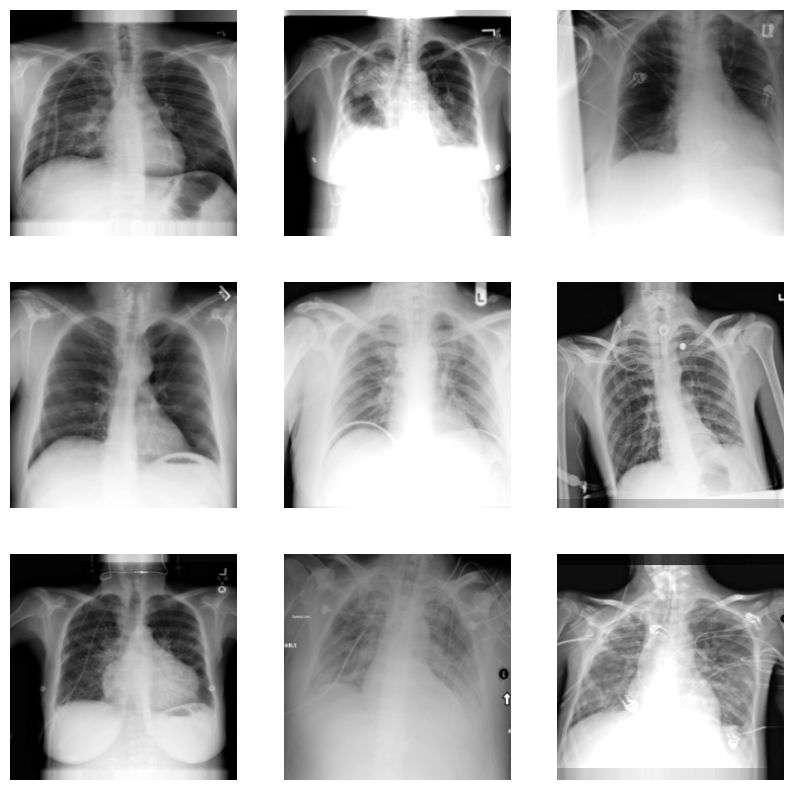

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming x_train is your training data
# Create an image augmentation object
datagen = ImageDataGenerator(
    brightness_range=[0.5, 1.5],  # Adjust brightness between 0.5 and 1.5
    zoom_range=0.2  # Randomly zoom images by 20%
)

# Fit the augmentation object to the training data
datagen.fit(x_train)

# Generate a batch of augmented images
augmented_images = next(datagen.flow(x_train, batch_size=9))

# Plot the augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].reshape(224, 224), cmap='gray')  # Assuming image size is 224x224
    plt.axis('off')

plt.show()



### Step 3. Use hyperparameter tuning and/or drop-out as needed

In [ ]:
import tensorflow as tf # Import tensorflow
from tensorflow import keras # Import keras from tensorflow
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # Import necessary layers
from tensorflow.keras.optimizers import Adam, RMSprop # Import optimizers

# Create model.
img_height, img_width, img_channels = 224, 224, 1
num_classes = 14
input_shape = (img_height, img_width, img_channels)
epochs = 100

# Define custom model class
class CustomModel(keras.Model):
    def __init__(self, num_layers=2, filters=16, kernel_size=(3, 3), strides=(1, 1), padding='valid', dropout_rate=0.5, optimizer='adam', learning_rate=0.001, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        self.model = keras.Sequential()
        self.model.add(Conv2D(self.filters, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, activation='relu', input_shape=(img_height, img_width, img_channels)))
        self.model.add(MaxPooling2D((2, 2)))

        for _ in range(self.num_layers - 1):
            self.model.add(Conv2D(self.filters, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, activation='relu'))
            self.model.add(MaxPooling2D((2, 2)))

        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dropout(self.dropout_rate))
        self.model.add(Dense(num_classes, activation='sigmoid'))

        if self.optimizer == 'adam':
            opt = keras.optimizers.Adam(learning_rate=self.learning_rate)
        elif self.optimizer == 'rmsprop':
            opt = keras.optimizers.RMSprop(learning_rate=self.learning_rate)
        else:
            raise ValueError("Invalid optimizer specified")

        self.model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    def call(self, inputs):
        return self.model(inputs)

    def fit(self, X, y, epochs=100, batch_size=32, **kwargs):
        return self.model.fit(X, y, epochs=epochs, batch_size=batch_size, **kwargs)

### Step 4. Create a deep learning model to use the training set images and predict the diagnosis of test set images. Include charts to show training/test accuracy and training/test losses.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.1949 - loss: 0.8193 - val_accuracy: 0.2484 - val_loss: 0.2263
Epoch 2/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2446 - loss: 0.2319 - val_accuracy: 0.2471 - val_loss: 0.2264
Epoch 3/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2468 - loss: 0.2290 - val_accuracy: 0.2494 - val_loss: 0.2248
Epoch 4/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2522 - loss: 0.2257 - val_accuracy: 0.2468 - val_loss: 0.2259
Epoch 5/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2533 - loss: 0.2230 - val_accuracy: 0.2435 - val_loss: 0.2267
Epoch 6/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2671 - loss: 0.2186 - val_accuracy: 0.2350 - val_loss: 0.2292
Epoch 7/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2810 - loss: 0.2133 - val_accuracy: 0.2268 - val_loss: 0.2322
Epoch 8/10
2277/2277 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3031 - loss: 0

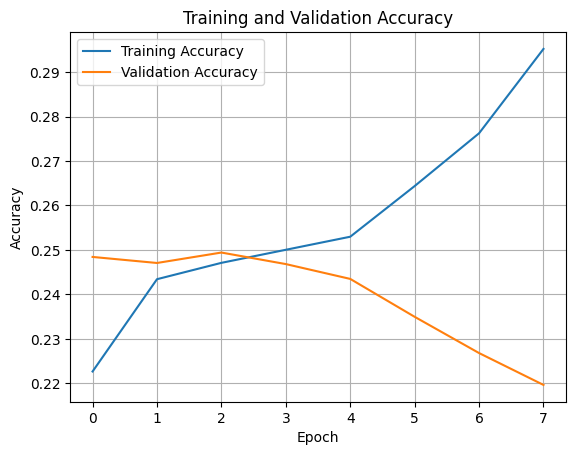

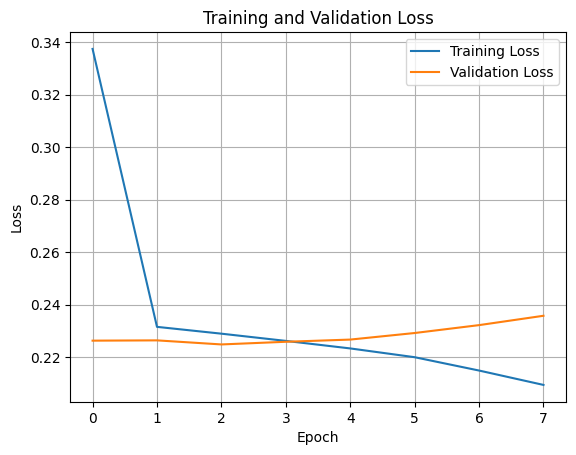

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop # Import optimizers
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping

# Create an instance of CustomModel
custom_model = CustomModel()

# Initialize parameters
epochs = 10
batch_size = 32

# 4 (b) Prevent too much underfitting and overfitting
# Initialize early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# 4 (a) Creating functional model and charts irrespective of accuracy
# Train the model
history = custom_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], validation_data=(x_test, y_test))

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1/5
Epoch 1/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.1913 - loss: 0.9904 - val_accuracy: 0.2460 - val_loss: 0.2282
Epoch 2/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2454 - loss: 0.2327 - val_accuracy: 0.2458 - val_loss: 0.2274
Epoch 3/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2470 - loss: 0.2292 - val_accuracy: 0.2441 - val_loss: 0.2274
Epoch 4/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2479 - loss: 0.2272 - val_accuracy: 0.2446 - val_loss: 0.2271
Epoch 5/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2565 - loss: 0.2237 - val_accuracy: 0.2407 - val_loss: 0.2269
Epoch 6/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2687 - loss: 0.2195 - val_accuracy: 0.2345 - val_loss: 0.2283
Epoch 7/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.2815 - loss: 0.2142 - val_accuracy: 0.2224 - val_loss: 0.2330
Epoch 8/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3126 - loss:

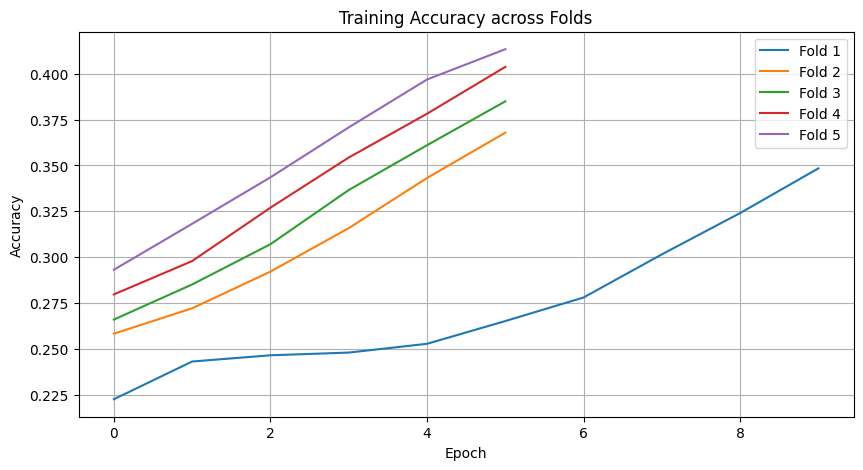

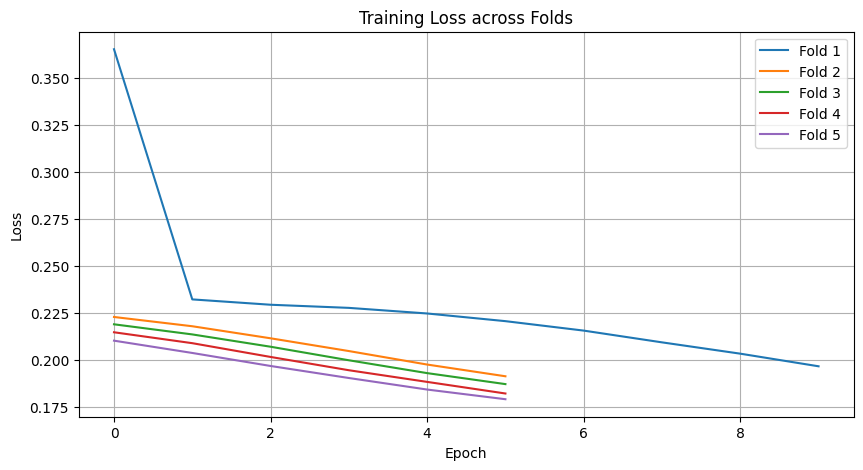

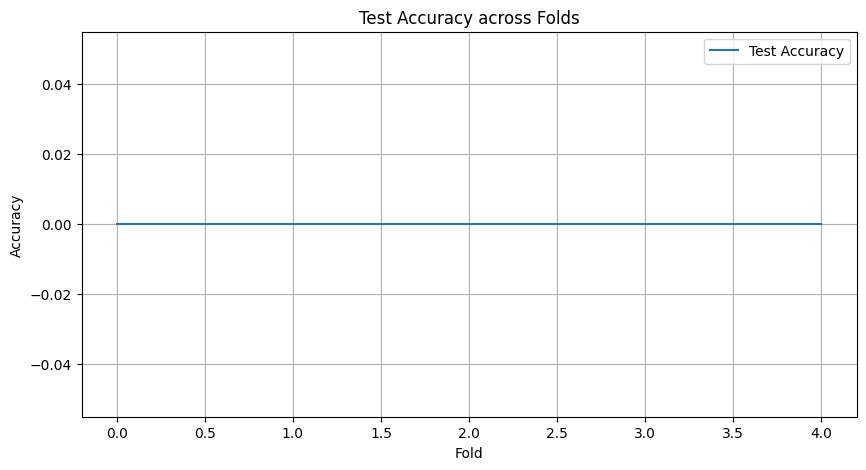

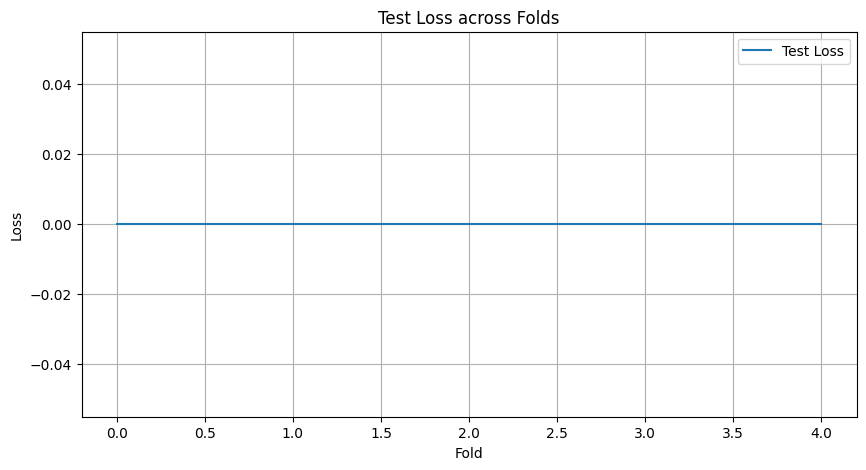

In [ ]:
# 4 (c) Evaluate if K-Fold Cross Validation helps improve accuracy or not
# Add this import statement at the beginning of your code
from sklearn.model_selection import KFold

num_folds = 5  # Number of folds for k-fold cross-validation

# Initialize lists to store fold-wise results
fold_histories = []

# Initialize lists to store test accuracy and loss for each fold
test_accuracy_per_fold = []
test_loss_per_fold = []

# Create k-fold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=False)

# Create an instance of CustomModel for each fold
custom_model = CustomModel()
custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Iterate over the folds
for fold, (train_indices, val_indices) in enumerate(kfold.split(x_train)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Initialize early stopping callback to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # Train the model for this fold
    history = custom_model.fit(x_train[train_indices], y_train[train_indices], epochs=epochs, batch_size=batch_size,
                               callbacks=[early_stopping], validation_data=(x_train[val_indices], y_train[val_indices]))

    # Append the fold history to the list
    fold_histories.append(history)

    # Evaluate the model on the test set and store accuracy and loss
   # test_loss, test_accuracy = custom_model.evaluate(x_test, y_test)
    test_results = custom_model.evaluate(x_test, y_test)

    # Extract the test loss and accuracy from the results tuple
    test_loss = test_results[0]
    test_accuracy = test_results[1]
    test_loss_per_fold.append(test_loss)
    test_accuracy_per_fold.append(test_accuracy)

# Plot training and validation accuracy across folds
plt.figure(figsize=(10, 5))
for fold, history in enumerate(fold_histories):
    plt.plot(history.history['accuracy'], label=f'Fold {fold + 1}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy across Folds')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss across folds
plt.figure(figsize=(10, 5))
for fold, history in enumerate(fold_histories):
    plt.plot(history.history['loss'], label=f'Fold {fold + 1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss across Folds')
plt.legend()
plt.grid(True)
plt.show()

# Plot test accuracy and loss for each fold
plt.figure(figsize=(10, 5))
plt.plot(test_accuracy_per_fold, label='Test Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Test Accuracy across Folds')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_loss_per_fold, label='Test Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Test Loss across Folds')
plt.legend()
plt.grid(True)
plt.show()